# STEP 1: Setup and Installation

In [12]:
# Import libraries
import pandas as pd
print(pd.__version__)
import os
import shutil
import yaml
from pathlib import Path
import sys

sys.path.append('/kaggle/usr/lib/notebooks/a21101131/yolov11-interface/notebooks/a21101131')

from yolov11_interface import YOLO
import cv2

2.2.2


# STEP 2: Dataset Preparation

In [13]:
SCRIPT_DIR = Path('/kaggle/working')  # Kaggle's writable directory
WORK_DIR = SCRIPT_DIR
DATASET_PATH = Path('/kaggle/input/datasets/lylmsc/wider-face-for-yolo-training')

if not DATASET_PATH.exists():
    print(f"Dataset not found at {DATASET_PATH}. Please ensure the 'dataset' folder is here.")
    sys.exit(1)
print(f"Using dataset at: {DATASET_PATH}")

Using dataset at: /kaggle/input/datasets/lylmsc/wider-face-for-yolo-training


# STEP 3: Convert CSV Annotations to YOLO Format

In [14]:
def prepare_wider_dataset():
    """
    Organize the WIDER Face dataset for YOLO training.
    The dataset is already in YOLO format, so we just need to split it into train/val/test sets.
    """
    # Create directory structure in /kaggle/working
    dirs = ['images/train', 'images/val', 'images/test',
            'labels/train', 'labels/val', 'labels/test']
    for d in dirs:
        os.makedirs(f'{WORK_DIR}/{d}', exist_ok=True)

    # Source directories
    source_images = DATASET_PATH / 'images'
    source_labels = DATASET_PATH / 'labels'

    if not source_images.exists() or not source_labels.exists():
        print(f"⚠️ Error: Expected 'images' and 'labels' folders in {DATASET_PATH}")
        sys.exit(1)

    # Get all image files
    image_files = sorted(list(source_images.glob('*.jpg')))
    if len(image_files) == 0:
        image_files = sorted(list(source_images.glob('*.png')))
    
    print(f"\nFound {len(image_files)} images in the dataset")

    # Split dataset: 80% train, 10% val, 10% test
    total = len(image_files)
    train_split = int(total * 0.8)
    val_split = int(total * 0.9)

    splits = {
        'train': image_files[:train_split],
        'val': image_files[train_split:val_split],
        'test': image_files[val_split:]
    }

    # Copy files to respective directories
    for split_name, files in splits.items():
        print(f"\nProcessing {split_name} split ({len(files)} images)...")
        
        processed_images = 0
        processed_labels = 0
        missing_labels = 0

        for img_path in files:
            # Copy image
            dst_img = WORK_DIR / 'images' / split_name / img_path.name
            shutil.copy(img_path, dst_img)
            processed_images += 1

            # Copy corresponding label file
            label_name = img_path.stem + '.txt'
            src_label = source_labels / label_name
            dst_label = WORK_DIR / 'labels' / split_name / label_name

            if src_label.exists():
                shutil.copy(src_label, dst_label)
                processed_labels += 1
            else:
                # Create empty label file if no annotations
                dst_label.touch()
                missing_labels += 1

        print(f"  ✓ Copied {processed_images} images")
        print(f"  ✓ Copied {processed_labels} labels")
        if missing_labels > 0:
            print(f"  ⚠️ Created {missing_labels} empty label files (no faces in these images)")

    print("\n" + "="*60)
    print("WIDER Face dataset preparation complete!")
    print("="*60)

# Run dataset preparation
prepare_wider_dataset()



Found 12880 images in the dataset

Processing train split (10304 images)...
  ✓ Copied 10304 images
  ✓ Copied 10304 labels

Processing val split (1288 images)...
  ✓ Copied 1288 images
  ✓ Copied 1288 labels

Processing test split (1288 images)...
  ✓ Copied 1288 images
  ✓ Copied 1288 labels

WIDER Face dataset preparation complete!


# STEP 5: Create data.yaml Configuration File

In [15]:
data_yaml = {
    'path': str(WORK_DIR),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': 1,  # number of classes
    'names': ['face']  # class names
}

with open(f'{WORK_DIR}/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("\ndata.yaml created:")
print(yaml.dump(data_yaml, default_flow_style=False))


data.yaml created:
names:
- face
nc: 1
path: /kaggle/working
test: images/test
train: images/train
val: images/val



# STEP 6: Verify Dataset

In [17]:
def verify_dataset():
    """Check dataset integrity"""
    train_images = len(os.listdir(f'{WORK_DIR}/images/train'))
    train_labels = len(os.listdir(f'{WORK_DIR}/labels/train'))
    val_images = len(os.listdir(f'{WORK_DIR}/images/val'))
    val_labels = len(os.listdir(f'{WORK_DIR}/labels/val'))
    test_images = len(os.listdir(f'{WORK_DIR}/images/test'))
    test_labels = len(os.listdir(f'{WORK_DIR}/labels/test'))

    print("\nDataset Summary:")
    print(f"Train - Images: {train_images}, Labels: {train_labels}")
    print(f"Val   - Images: {val_images}, Labels: {val_labels}")
    print(f"Test  - Images: {test_images}, Labels: {test_labels}")

    # Sample a label file to verify format
    if train_labels > 0:
        sample_label = os.listdir(f'{WORK_DIR}/labels/train')[0]
        print(f"\nSample label file ({sample_label}):")
        with open(f'{WORK_DIR}/labels/train/{sample_label}', 'r') as f:
            lines = f.readlines()[:3]  # Show first 3 annotations
            for line in lines:
                print(f"  {line.strip()}")
            if len(lines) > 3:
                print(f"  ... and more")

    if train_images == 0 or val_images == 0:
        print("\n⚠️ WARNING: No images found! Please check dataset organization.")
    elif train_images != train_labels or val_images != val_labels:
        print("\n⚠️ WARNING: Mismatch between images and labels!")
    else:
        print("\n✓ Dataset looks good!")

verify_dataset()


Dataset Summary:
Train - Images: 11425, Labels: 11425
Val   - Images: 1325, Labels: 1325
Test  - Images: 1424, Labels: 1424

Sample label file (wider_12739.txt):
  0 0.2841796875 0.45975232198142413 0.435546875 0.8204334365325078

✓ Dataset looks good!


# STEP 7: Initialize YOLOv11 Model

In [18]:
# Load a pretrained YOLOv11 model (nano, small, medium, large, or extra-large)
model = YOLO('yolo11n.pt')  # 'n' for nano (fastest), 's', 'm', 'l', 'x' for larger models

print("\nModel loaded successfully!")

Initializing new YOLOv11N model...

Model loaded successfully!


# STEP 8: Train the Model

In [19]:
print("\nStarting training...")

# Training parameters
results = model.train(
    data=str(WORK_DIR / 'data.yaml'),
    epochs=10,                # Number of training epochs
    imgsz=640,                 # Image size
    batch=16,                  # Batch size (reduce if out of memory)
    device=0,                  # Use GPU 0 (use 'cpu' if no GPU)
    workers=2,                 # Number of workers
    project=str(WORK_DIR),     # Save runs in script directory
    name='yolov11_face',       # Experiment name
    patience=20,               # Early stopping patience
    save=True,                 # Save checkpoints
    plots=True,                # Create plots
    # Augmentation parameters
    hsv_h=0.015,              # HSV-Hue augmentation
    hsv_s=0.7,                # HSV-Saturation augmentation
    hsv_v=0.4,                # HSV-Value augmentation
    degrees=0.0,              # Rotation (+/- deg)
    translate=0.1,            # Translation (+/- fraction)
    scale=0.5,                # Scale (+/- gain)
    flipud=0.0,               # Flip up-down probability
    fliplr=0.5,               # Flip left-right probability
    mosaic=1.0,               # Mosaic augmentation probability
)

print("\nTraining complete!")


Starting training...
Found 11425 images in /kaggle/working/images/train
Found 1325 images in /kaggle/working/images/val

Starting training for 10 epochs...
Device: cuda
Training images: 11425
Validation images: 1325

Epoch 1/10


Training: 100%|██████████| 715/715 [06:31<00:00,  1.83it/s, loss=9.1459, avg_loss=9.0172]  



Epoch 2/10


Training: 100%|██████████| 715/715 [06:32<00:00,  1.82it/s, loss=6.4550, avg_loss=6.9087]



Epoch 3/10


Training: 100%|██████████| 715/715 [06:29<00:00,  1.83it/s, loss=7.5173, avg_loss=6.2985]



Epoch 4/10


Training: 100%|██████████| 715/715 [06:30<00:00,  1.83it/s, loss=9.2129, avg_loss=5.9382]



Epoch 5/10


Training: 100%|██████████| 715/715 [06:30<00:00,  1.83it/s, loss=4.1540, avg_loss=5.6850]



Validating...


Validation: 100%|██████████| 83/83 [00:14<00:00,  5.64it/s]



Validation Results:
  mAP@0.5: 0.1950
  mAP@0.5:0.95: 0.1170
  Precision: 0.1511
  Recall: 0.2751
  (TP=2082, FP=11701, GT=7568)
New best model saved! mAP@0.5: 0.1950

Epoch 6/10


Training: 100%|██████████| 715/715 [06:30<00:00,  1.83it/s, loss=3.7170, avg_loss=5.4924]



Epoch 7/10


Training: 100%|██████████| 715/715 [06:30<00:00,  1.83it/s, loss=6.4710, avg_loss=5.3246]



Epoch 8/10


Training: 100%|██████████| 715/715 [06:29<00:00,  1.84it/s, loss=4.9974, avg_loss=5.2403]



Epoch 9/10


Training: 100%|██████████| 715/715 [06:29<00:00,  1.83it/s, loss=2.6954, avg_loss=5.1549]



Epoch 10/10


Training: 100%|██████████| 715/715 [06:29<00:00,  1.84it/s, loss=2.6986, avg_loss=5.0938]



Validating...


Validation: 100%|██████████| 83/83 [00:15<00:00,  5.38it/s]



Validation Results:
  mAP@0.5: 0.1438
  mAP@0.5:0.95: 0.0863
  Precision: 0.0895
  Recall: 0.3663
  (TP=2772, FP=28211, GT=7568)

Training complete!

Training complete!


# STEP 9: Evaluate the Model

In [20]:
# Load the best model
best_model = YOLO(str(WORK_DIR / 'yolov11_face' / 'weights' / 'best.pt'))

# Validate
metrics = best_model.val()

print("\nValidation Metrics:")
print(f"mAP50: {metrics.map50:.4f}")
print(f"mAP50-95: {metrics.map:.4f}")
print(f"Precision: {metrics.mp:.4f}")
print(f"Recall: {metrics.mr:.4f}")

Loading weights from /kaggle/working/yolov11_face/weights/best.pt...
Model loaded successfully!
No trainer available. Please train the model first or provide data config.

Validation Metrics:
mAP50: 0.0000
mAP50-95: 0.0000
Precision: 0.0000
Recall: 0.0000


# STEP 10: Test on Sample Images


Running inference on sample images...


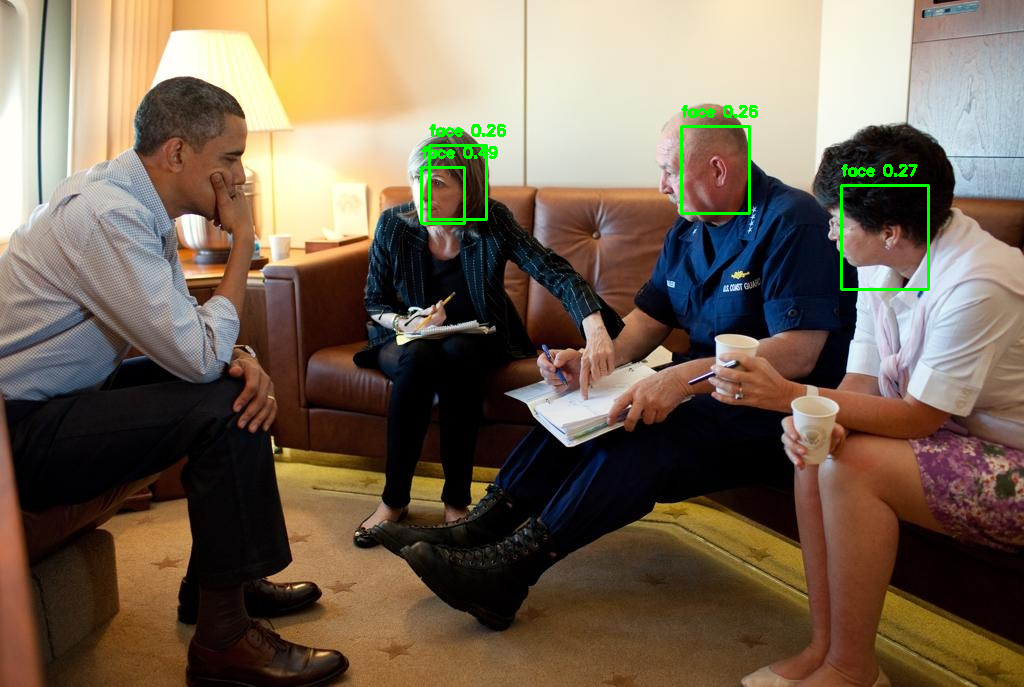

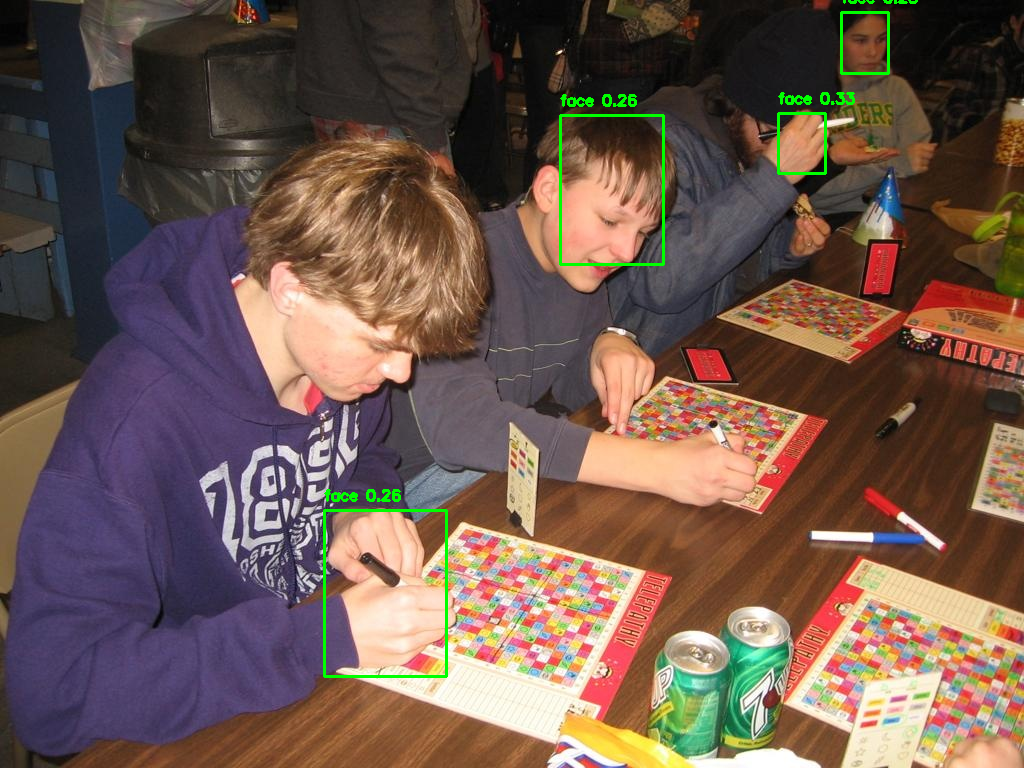

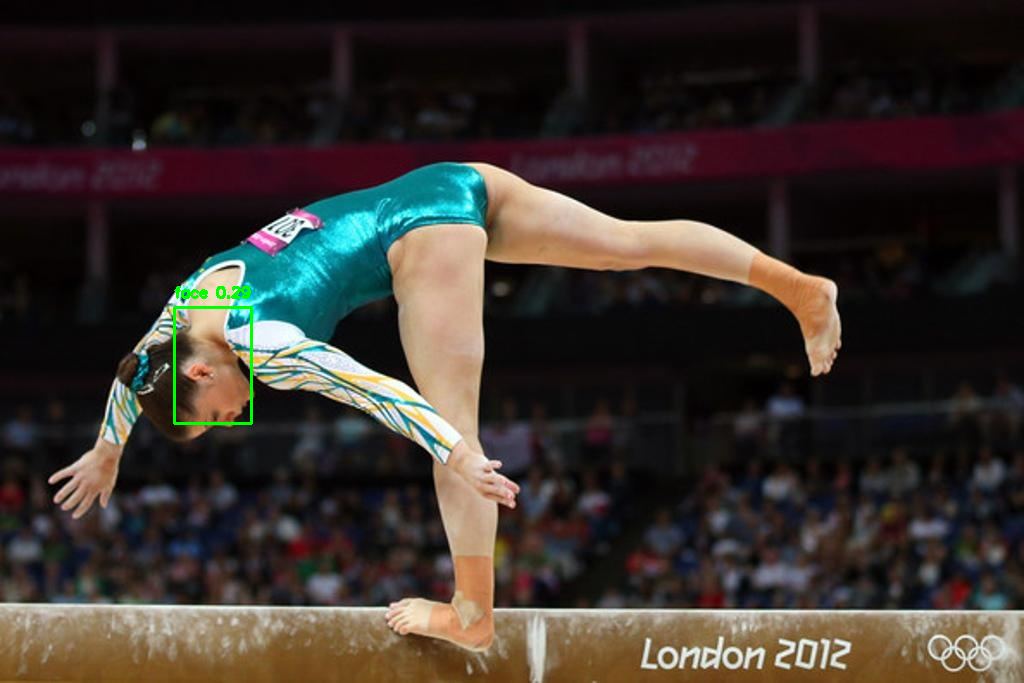

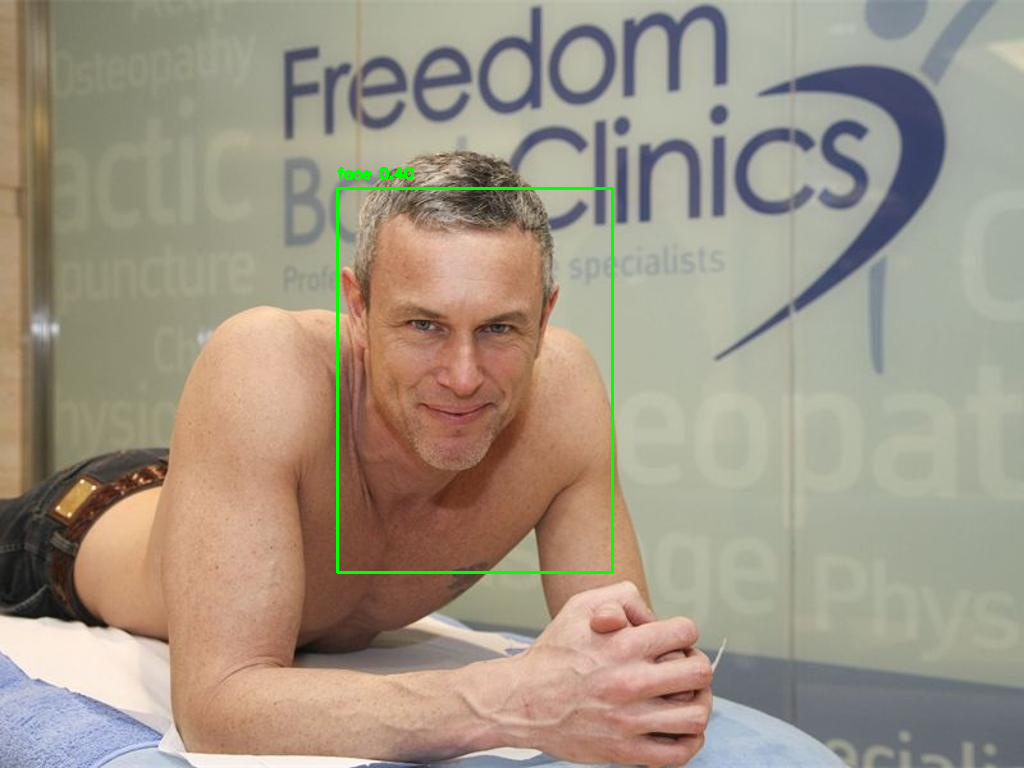

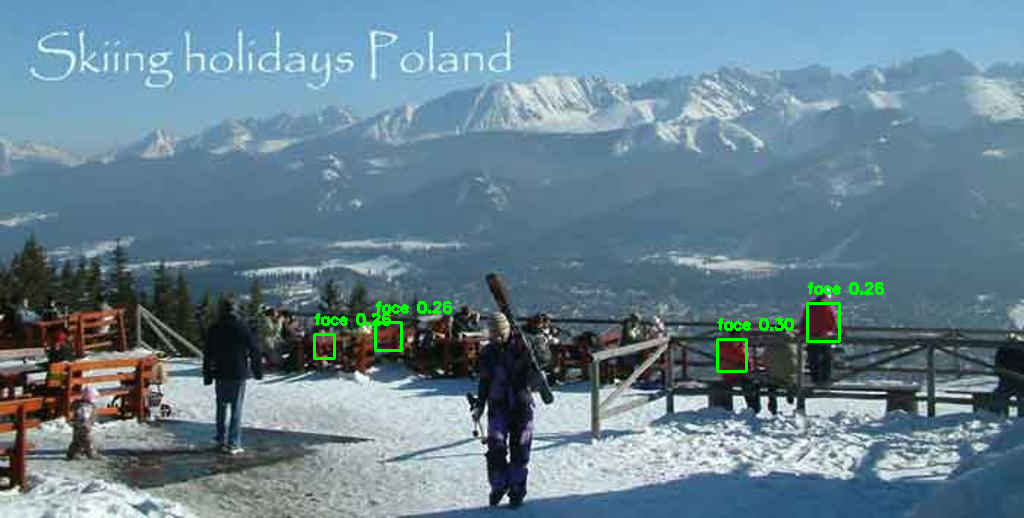

In [21]:
import glob
from PIL import Image as PILImage

val_images = glob.glob(f'{WORK_DIR}/images/val/*.jpg')
if not val_images:
    val_images = glob.glob(f'{WORK_DIR}/images/val/*.png')
val_images = val_images[:5]  # Take first 5 images

print("\nRunning inference on sample images...")

os.makedirs(WORK_DIR / 'sample_outputs', exist_ok=True)
for img_path in val_images:
    results = best_model.predict(str(img_path))

    # Display or save results
    for r in results:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = PILImage.fromarray(im_array[..., ::-1])  # RGB PIL image
        display(im)

# STEP 11: Export Model

In [10]:
# Export to different formats
print("\nExporting model...")

# Export to ONNX (for deployment)
best_model.export(format='onnx')

# Export to TensorRT (for NVIDIA devices)
# best_model.export(format='engine')

# Export to TFLite (for mobile)
# best_model.export(format='tflite')

print("\n✓ Model exported successfully!")


Exporting model...
Exporting model to onnx...


/kaggle/usr/lib/notebooks/a21101131/yolov11-model/notebooks/a21101131/yolov11_model.py:190: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i, stride in enumerate(strides):


Model exported to yolov11n.onnx

✓ Model exported successfully!


# STEP 12: Save Model Locally

In [11]:
# Copy best model to a local folder (same directory as script)
output_dir = WORK_DIR / 'saved_model'
output_dir.mkdir(parents=True, exist_ok=True)

weights_dir = WORK_DIR / 'yolov11_face' / 'weights'
for name in ('best.pt', 'last.pt'):
    src = weights_dir / name
    if src.exists():
        shutil.copy(src, output_dir / name)

print(f"\n✓ Models saved to: {output_dir}")


✓ Models saved to: /kaggle/working/saved_model
